# ebnodb2no

In [50]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = 8
BATCH_SIZE = 2
EBN0_DB_MIN = -3.0
EBN0_DB_MAX = 3.0

for EBN0_DB in np.linspace(EBN0_DB_MIN,EBN0_DB_MAX,20):
    print('EBN0_DB =',EBN0_DB)
    no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                            num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                            coderate=1.0)
    print('no =',no)


EBN0_DB = -3.0
no = tf.Tensor(0.4988156, shape=(), dtype=float32)
EBN0_DB = -2.6842105263157894
no = tf.Tensor(0.46383238, shape=(), dtype=float32)
EBN0_DB = -2.3684210526315788
no = tf.Tensor(0.43130267, shape=(), dtype=float32)
EBN0_DB = -2.0526315789473686
no = tf.Tensor(0.4010543, shape=(), dtype=float32)
EBN0_DB = -1.736842105263158
no = tf.Tensor(0.37292734, shape=(), dtype=float32)
EBN0_DB = -1.4210526315789473
no = tf.Tensor(0.346773, shape=(), dtype=float32)
EBN0_DB = -1.105263157894737
no = tf.Tensor(0.32245293, shape=(), dtype=float32)
EBN0_DB = -0.7894736842105265
no = tf.Tensor(0.29983848, shape=(), dtype=float32)
EBN0_DB = -0.47368421052631593
no = tf.Tensor(0.27881005, shape=(), dtype=float32)
EBN0_DB = -0.1578947368421053
no = tf.Tensor(0.2592564, shape=(), dtype=float32)
EBN0_DB = 0.1578947368421053
no = tf.Tensor(0.2410741, shape=(), dtype=float32)
EBN0_DB = 0.4736842105263155
no = tf.Tensor(0.22416694, shape=(), dtype=float32)
EBN0_DB = 0.7894736842105261
no = tf.Ten

# AWGN (Additive White Gaussian **Noise**)

In [95]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils import expand_to_rank, complex_normal

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = 8
BATCH_SIZE = 2
EBN0_DB = -10

# Binary source
binary_source = sn.utils.BinarySource()

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])
print('bits =\n',bits)

no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0)
print('no =',no)

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)

x = mapper(bits)
print('x =\n',x)
 
# Create tensors of real-valued Gaussian noise for each complex dim.
noise = complex_normal(tf.shape(x), dtype=x.dtype)
print('noise =\n',noise)

# Add extra dimensions for broadcasting
no = expand_to_rank(no, tf.rank(x), axis=-1)
print('no =',no)

# Apply variance scaling
real_dtype = tf.dtypes.as_dtype(tf.complex64).real_dtype
no = tf.cast(no, real_dtype)
print('no =',no)
noise *= tf.cast(tf.sqrt(no), noise.dtype)
print('noise =\n',noise)

# Add noise to input
y = x + noise
#print('y = x + noise =\n',y)


bits =
 tf.Tensor(
[[1. 1. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 1. 1. 1.]], shape=(2, 8), dtype=float32)
no = tf.Tensor(2.5, shape=(), dtype=float32)
x =
 tf.Tensor(
[[-0.9486833-0.9486833j -0.3162278+0.3162278j]
 [ 0.9486833-0.9486833j  0.9486833-0.9486833j]], shape=(2, 2), dtype=complex64)
noise =
 tf.Tensor(
[[-0.2457148 -0.4940561j  -0.2502328 +0.0766773j ]
 [ 0.6659922 -0.00514933j  0.40934482-0.22090244j]], shape=(2, 2), dtype=complex64)
no = tf.Tensor([[2.5]], shape=(1, 1), dtype=float32)
no = tf.Tensor([[2.5]], shape=(1, 1), dtype=float32)
noise =
 tf.Tensor(
[[-0.3885092 -0.7811713j  -0.39565277+0.12123746j]
 [ 1.0530262 -0.00814181j  0.647231  -0.34927744j]], shape=(2, 2), dtype=complex64)


# logits2llrs

In [87]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

def SymbolLogits2LLRs(method, num_bits_per_symbol, hard_out=False, with_prior=False, dtype=tf.float32, **kwargs):
    # pylint: disable=line-too-long
    r"""
    SymbolLogits2LLRs(method, num_bits_per_symbol, hard_out=False, with_prior=False, dtype=tf.float32, **kwargs)

    Computes log-likelihood ratios (LLRs) or hard-decisions on bits
    from a tensor of logits (i.e., unnormalized log-probabilities) on constellation points.
    If the flag ``with_prior`` is set, prior knowledge on the bits is assumed to be available.

    Parameters
    ----------
    method : One of ["app", "maxlog"], str
        The method used for computing the LLRs.

    num_bits_per_symbol : int
        The number of bits per constellation symbol, e.g., 4 for QAM16.

    hard_out : bool
        If `True`, the layer provides hard-decided bits instead of soft-values.
        Defaults to `False`.

    with_prior : bool
        If `True`, it is assumed that prior knowledge on the bits is available.
        This prior information is given as LLRs as an additional input to the layer.
        Defaults to `False`.

    dtype : One of [tf.float32, tf.float64] tf.DType (dtype)
        The dtype for the input and output.
        Defaults to `tf.float32`.

    Input
    -----
    logits or (logits, prior):
        Tuple:

    logits : [...,n, num_points], tf.float
        Logits on constellation points.

    prior : [num_bits_per_symbol] or [...n, num_bits_per_symbol], tf.float
        Prior for every bit as LLRs.
        It can be provided either as a tensor of shape `[num_bits_per_symbol]`
        for the entire input batch, or as a tensor that is "broadcastable"
        to `[..., n, num_bits_per_symbol]`.
        Only required if the ``with_prior`` flag is set.

    Output
    ------
    : [...,n, num_bits_per_symbol], tf.float
        LLRs or hard-decisions for every bit.

    Note
    ----
    With the "app" method, the LLR for the :math:`i\text{th}` bit
    is computed according to

    .. math::
        LLR(i) = \ln\left(\frac{\Pr\left(b_i=1\lvert \mathbf{z},\mathbf{p}\right)}{\Pr\left(b_i=0\lvert \mathbf{z},\mathbf{p}\right)}\right) =\ln\left(\frac{
                \sum_{c\in\mathcal{C}_{i,1}} \Pr\left(c\lvert\mathbf{p}\right)
                e^{z_c}
                }{
                \sum_{c\in\mathcal{C}_{i,0}} \Pr\left(c\lvert\mathbf{p}\right)
                e^{z_c}
                }\right)

    where :math:`\mathcal{C}_{i,1}` and :math:`\mathcal{C}_{i,0}` are the
    sets of :math:`2^K` constellation points for which the :math:`i\text{th}` bit is
    equal to 1 and 0, respectively. :math:`\mathbf{z} = \left[z_{c_0},\dots,z_{c_{2^K-1}}\right]` is the vector of logits on the constellation points, :math:`\mathbf{p} = \left[p_0,\dots,p_{K-1}\right]`
    is the vector of LLRs that serves as prior knowledge on the :math:`K` bits that are mapped to
    a constellation point and is set to :math:`\mathbf{0}` if no prior knowledge is assumed to be available,
    and :math:`\Pr(c\lvert\mathbf{p})` is the prior probability on the constellation symbol :math:`c`:

    .. math::
        \Pr\left(c\lvert\mathbf{p}\right) = \prod_{k=0}^{K-1} \Pr\left(b_k = \ell(c)_k \lvert\mathbf{p} \right)
        = \prod_{k=0}^{K-1} \text{sigmoid}\left(p_k \ell(c)_k\right)

    where :math:`\ell(c)_k` is the :math:`k^{th}` bit label of :math:`c`, where 0 is
    replaced by -1.
    The definition of the LLR has been
    chosen such that it is equivalent with that of logits. This is
    different from many textbooks in communications, where the LLR is
    defined as :math:`LLR(i) = \ln\left(\frac{\Pr\left(b_i=0\lvert y\right)}{\Pr\left(b_i=1\lvert y\right)}\right)`.

    With the "maxlog" method, LLRs for the :math:`i\text{th}` bit
    are approximated like

    .. math::
        \begin{align}
            LLR(i) &\approx\ln\left(\frac{
                \max_{c\in\mathcal{C}_{i,1}} \Pr\left(c\lvert\mathbf{p}\right)
                    e^{z_c}
                }{
                \max_{c\in\mathcal{C}_{i,0}} \Pr\left(c\lvert\mathbf{p}\right)
                    e^{z_c}
                }\right)
                .
        \end{align}
    """
    def __init__(self,
                 method,
                 num_bits_per_symbol,
                 hard_out=False,
                 with_prior=False,
                 dtype=tf.float32,
                 **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert method in ("app","maxlog"), "Unknown demapping method"
        self._method = method
        self._hard_out = hard_out
        self._num_bits_per_symbol = num_bits_per_symbol
        self._with_prior = with_prior
        num_points = int(2**num_bits_per_symbol)

        # Array composed of binary representations of all symbols indices
        a = np.zeros([num_points, num_bits_per_symbol])
        for i in range(0, num_points):
            a[i,:] = np.array(list(np.binary_repr(i, num_bits_per_symbol)),
                              dtype=np.int16)

        # Compute symbol indices for which the bits are 0 or 1
        c0 = np.zeros([int(num_points/2), num_bits_per_symbol])
        c1 = np.zeros([int(num_points/2), num_bits_per_symbol])
        for i in range(num_bits_per_symbol-1,-1,-1):
            c0[:,i] = np.where(a[:,i]==0)[0]
            c1[:,i] = np.where(a[:,i]==1)[0]
        self._c0 = tf.constant(c0, dtype=tf.int32) # Symbols with ith bit=0
        self._c1 = tf.constant(c1, dtype=tf.int32) # Symbols with ith bit=1

        if with_prior:
            # Array of labels from {-1, 1} of all symbols
            # [num_points, num_bits_per_symbol]
            a = 2*a-1
            self._a = tf.constant(a, dtype=dtype)

        # Determine the reduce function for LLR computation
        if self._method == "app":
            self._reduce = tf.reduce_logsumexp
        else:
            self._reduce = tf.reduce_max

    @property
    def num_bits_per_symbol(self):
        return self._num_bits_per_symbol

    def call(self, inputs):
        if self._with_prior:
            logits, prior = inputs
        else:
            logits = inputs

        # Compute exponents
        exponents = logits

        # Gather exponents for all bits
        # shape [...,n,num_points/2,num_bits_per_symbol]
        exp0 = tf.gather(exponents, self._c0, axis=-1, batch_dims=0)
        exp1 = tf.gather(exponents, self._c1, axis=-1, batch_dims=0)

        # Process the prior information
        if self._with_prior:
            # Expanding `prior` such that it is broadcastable with
            # shape [..., n or 1, 1, num_bits_per_symbol]
            prior = sn.utils.expand_to_rank(prior, tf.rank(logits), axis=0)
            prior = tf.expand_dims(prior, axis=-2)

            # Expand the symbol labeling to be broadcastable with prior
            # shape [..., 1, num_points, num_bits_per_symbol]
            a = sn.utils.expand_to_rank(self._a, tf.rank(prior), axis=0)

            # Compute the prior probabilities on symbols exponents
            # shape [..., n or 1, num_points]
            exp_ps = tf.reduce_sum(tf.math.log_sigmoid(a*prior), axis=-1)

            # Gather prior probability symbol for all bits
            # shape [..., n or 1, num_points/2, num_bits_per_symbol]
            exp_ps0 = tf.gather(exp_ps, self._c0, axis=-1)
            exp_ps1 = tf.gather(exp_ps, self._c1, axis=-1)

        # Compute LLRs using the definition log( Pr(b=1)/Pr(b=0) )
        # shape [..., n, num_bits_per_symbol]
        if self._with_prior:
            llr = self._reduce(exp_ps1 + exp1, axis=-2)\
                    - self._reduce(exp_ps0 + exp0, axis=-2)
        else:
            llr = self._reduce(exp1, axis=-2) - self._reduce(exp0, axis=-2)

        if self._hard_out:
            return sn.utils.hard_decisions(llr)
        else:
            return llr

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = 8
BATCH_SIZE = 2
EBN0_DB = -10

# Binary source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)

# AWGN channel
awgn_channel = sn.channel.AWGN()

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])
#print('bits =\n',bits)

no = sn.utils.ebnodb2no(ebno_db=EBN0_DB,
                        num_bits_per_symbol=NUM_BITS_PER_SYMBOL,
                        coderate=1.0)
#print('no =',no)

x = mapper(bits)
#print('x =\n',x)

y = awgn_channel([x, no])

# Reshape constellation points to [1,...1,num_points]
points_shape = [1]*y.shape.rank + constellation.points.shape
points = tf.reshape(constellation.points, points_shape)

# Compute squared distances from y to all points
# shape [...,n,num_points]
squared_dist = tf.pow(tf.abs(tf.expand_dims(y, axis=-1) - points), 2)

# Add a dummy dimension for broadcasting. This is not needed when no
# is a scalar, but also does not do any harm.
no = tf.expand_dims(no, axis=-1)

# Compute exponents
exponents = -squared_dist/no
#print('exponents =\n',exponents)

logits2llrs = SymbolLogits2LLRs("app",NUM_BITS_PER_SYMBOL)
print('logits2llrs =\n',logits2llrs)

# if self._with_prior:
#     llr = self._logits2llrs([exponents, prior])
# else:
llr = logits2llrs(exponents)

# Reshape LLRs to [...,n*num_bits_per_symbol]
out_shape = tf.concat([tf.shape(y)[:-1],
                        [y.shape[-1] * \
                        constellation.num_bits_per_symbol]], 0)
llr_reshaped = tf.reshape(llr, out_shape)

# return llr_reshaped

logits2llrs =
 None


TypeError: 'NoneType' object is not callable

# bits2symbol

## Test

In [ ]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

CODERATE = 0.5
n = 16
k = int(n*CODERATE)

NUM_BITS_PER_SYMBOL = 4 # QPSK
print('NUM_BITS_PER_SYMBOL =',NUM_BITS_PER_SYMBOL)
BLOCK_LENGTH = k
BATCH_SIZE = 2 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -10.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10.0 # Maximum value of Eb/N0 [dB] for simulations

# Binary source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)

bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])
print('bits =\n',bits)

new_shape = [-1] + bits.shape[1:-1].as_list() + \
           [int(bits.shape[-1] / NUM_BITS_PER_SYMBOL),
            NUM_BITS_PER_SYMBOL]
print('new_shape =\n',new_shape)

bits_reshaped = tf.cast(tf.reshape(bits, new_shape), tf.int32)
print('symbols =\n',bits_reshaped)

binary_base = 2**tf.constant(
                        range(NUM_BITS_PER_SYMBOL-1,-1,-1))
print('binary_base =\n',binary_base)

int_rep = tf.reduce_sum(bits_reshaped * binary_base, axis=-1)
print('int_rep =\n',int_rep)

x = tf.gather(constellation.points, int_rep, axis=0)
print(x)

## Release

In [49]:
# Imports & Basics

# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

# For plotting
%matplotlib inline
# also try %matplotlib widget

import matplotlib.pyplot as plt

# for performance measurements
import time

# For the implementation of the Keras models
from tensorflow.keras import Model

from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber, compute_ser

def bits2symbol(bits,num_bits_per_symbol):
    new_shape = [-1] + bits.shape[1:-1].as_list() + \
            [int(bits.shape[-1] / NUM_BITS_PER_SYMBOL),
                NUM_BITS_PER_SYMBOL]
    #print('new_shape =',new_shape)
    #print('bits.shape[1:-1]',bits.shape[1:-1])
    # print('bits.shape[-1]=',bits.shape[-1])

    symbols = tf.cast(tf.reshape(bits, new_shape), tf.int32)
    # print('symbols =',symbols)
    return symbols


CODERATE = 0.5
n = 16
k = int(n*CODERATE)

NUM_BITS_PER_SYMBOL = 4 # QPSK
BLOCK_LENGTH = k
BATCH_SIZE = 2 # How many examples are processed by Sionna in parallel
EBN0_DB_MIN = -10.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 10.0 # Maximum value of Eb/N0 [dB] for simulations

# Binary source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)

#bits = binary_source([BATCH_SIZE,BLOCK_LENGTH])
bits = binary_source([2,3,4,5,6])
# print('bits =',bits)
# print('bits.ndim =',bits.ndim)

symbols = bits2symbol(bits,NUM_BITS_PER_SYMBOL)
# print('symbols =',symbols)

In [46]:
# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn

import tensorflow as tf
import numpy as np
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder

BATCH_SIZE = 1000000
NUM_TX_ANT = 4
NUM_RX_ANT = 16
NUM_BITS_PER_SYMBOL = 4

channel = FlatFadingChannel(num_tx_ant=NUM_TX_ANT, num_rx_ant=NUM_RX_ANT, add_awgn=True, return_channel=True)
no = 0.2 # Noise variance of the channel
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)
qam_source = QAMSource(num_bits_per_symbol=NUM_BITS_PER_SYMBOL)
x = qam_source([BATCH_SIZE, NUM_TX_ANT])
# print('x =',x)
# Get symbol indices for the transmitted symbols
x_ind = symbol_demapper([x, no])
# print('x_ind =',x_ind)

# Create transmit and receive correlation matrices
r_tx = exp_corr_mat(0.4, NUM_TX_ANT)
r_rx = exp_corr_mat(0.9, NUM_RX_ANT)

print('r_tx =',r_tx)
print('r_rx =',r_rx)
print('r_tx.shape =',r_tx.shape)
print('r_rx.shape =',r_rx.shape)

# Add the spatial correlation model to the channel
channel.spatial_corr = KroneckerModel(r_tx, r_rx)
#print('h_corr =',KroneckerModel(r_tx, r_rx))

h = channel.generate(BATCH_SIZE)
print('h.shape =',h.shape)

# Compute empirical covariance matrices
r_tx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_a=True), 0)/NUM_RX_ANT
r_rx_hat = tf.reduce_mean(tf.matmul(h, h, adjoint_b=True), 0)/NUM_TX_ANT

# Test that the empirical results match the theory
# assert(np.allclose(r_tx, r_tx_hat, atol=1e-2))
# assert(np.allclose(r_rx, r_rx_hat, atol=1e-2))

y, h = channel([x, no]) # type: ignore
s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)
x_hat, no_eff = lmmse_equalizer(y, h, s)

# Get symbol indices for the received soft-symbols
x_ind_hat = symbol_demapper([x_hat, no])
compute_ser(x_ind, x_ind_hat)

r_tx = tf.Tensor(
[[1.        +0.j 0.4       -0.j 0.16000001-0.j 0.06400001-0.j]
 [0.4       +0.j 1.        +0.j 0.4       -0.j 0.16000001-0.j]
 [0.16000001+0.j 0.4       +0.j 1.        +0.j 0.4       -0.j]
 [0.06400001+0.j 0.16000001+0.j 0.4       +0.j 1.        +0.j]], shape=(4, 4), dtype=complex64)
r_rx = tf.Tensor(
[[1.        +0.j 0.9       -0.j 0.80999994-0.j 0.7289999 -0.j
  0.6560999 -0.j 0.5904899 -0.j 0.5314409 -0.j 0.47829682-0.j
  0.4304671 -0.j 0.3874204 -0.j 0.34867835-0.j 0.3138105 -0.j
  0.28242943-0.j 0.25418648-0.j 0.22876784-0.j 0.20589103-0.j]
 [0.9       +0.j 1.        +0.j 0.9       -0.j 0.80999994-0.j
  0.7289999 -0.j 0.6560999 -0.j 0.5904899 -0.j 0.5314409 -0.j
  0.47829682-0.j 0.4304671 -0.j 0.3874204 -0.j 0.34867835-0.j
  0.3138105 -0.j 0.28242943-0.j 0.25418648-0.j 0.22876784-0.j]
 [0.80999994+0.j 0.9       +0.j 1.        +0.j 0.9       -0.j
  0.80999994-0.j 0.7289999 -0.j 0.6560999 -0.j 0.5904899 -0.j
  0.5314409 -0.j 0.47829682-0.j 0.4304671 -0.j 0.3874204 

<tf.Tensor: shape=(), dtype=float64, numpy=0.12131725>

# FlatFadingChannel

In [44]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from sionna.utils import expand_to_rank, complex_normal

from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber

# from sionna.channel import AWGN
from sionna.utils import complex_normal

class AWGN(Layer):
    def __init__(self, dtype=tf.complex64, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self._real_dtype = tf.dtypes.as_dtype(self._dtype).real_dtype

    def call(self, inputs):

        x, no = inputs

        # Create tensors of real-valued Gaussian noise for each complex dim.
        noise = complex_normal(tf.shape(x), dtype=x.dtype)

        # Add extra dimensions for broadcasting
        no = expand_to_rank(no, tf.rank(x), axis=-1)

        # Apply variance scaling
        no = tf.cast(no, self._real_dtype)
        noise *= tf.cast(tf.sqrt(no), noise.dtype)
        print('noise shape',noise.shape)
        # Add noise to input
        y = x + noise

        return y

class GenerateFlatFadingChannel():
    def __init__(self, num_tx_ant, num_rx_ant, spatial_corr=None, dtype=tf.complex64, **kwargs):
        super().__init__(**kwargs)
        self._num_tx_ant = num_tx_ant
        self._num_rx_ant = num_rx_ant
        self._dtype = dtype
        self.spatial_corr = spatial_corr
 
    @property
    def spatial_corr(self):
        """The :class:`~sionna.channel.SpatialCorrelation` to be used."""
        return self._spatial_corr
 
    @spatial_corr.setter
    def spatial_corr(self, value):
        self._spatial_corr = value
 
    def __call__(self, batch_size):
        # Generate standard complex Gaussian matrices
        shape = [batch_size, self._num_rx_ant, self._num_tx_ant]
        h = complex_normal(shape, dtype=self._dtype)
 
        # Apply spatial correlation
        if self.spatial_corr is not None:
            h = self.spatial_corr(h)
 
        return h

class ApplyFlatFadingChannel(tf.keras.layers.Layer):
    def __init__(self, add_awgn=True, dtype=tf.complex64, **kwargs):
        super().__init__(trainable=False, dtype=dtype, **kwargs)
        self._add_awgn = add_awgn
 
    def build(self, input_shape): #pylint: disable=unused-argument
        if self._add_awgn:
            self._awgn = AWGN(dtype=self.dtype)
 
    def call(self, inputs):
        if self._add_awgn:
            x, h, no = inputs
        else:
            x, h = inputs
 
        x = tf.expand_dims(x, axis=-1)
        print('x reshape app_chn',x.shape)
        y = tf.matmul(h, x)
        y = tf.squeeze(y, axis=-1)
 
        if self._add_awgn:
            y = self._awgn((y, no))
 
        return y

class FlatFadingChannel(tf.keras.layers.Layer):
    def __init__(self,
                 num_tx_ant,
                 num_rx_ant,
                 spatial_corr=None,
                 add_awgn=True,
                 return_channel=False,
                 dtype=tf.complex64,
                 **kwargs):
        super().__init__(trainable=False, dtype=dtype, **kwargs)
        self._num_tx_ant = num_tx_ant
        self._num_rx_ant = num_rx_ant
        self._add_awgn = add_awgn
        self._return_channel = return_channel
        self._gen_chn = GenerateFlatFadingChannel(self._num_tx_ant,
                                                  self._num_rx_ant,
                                                  spatial_corr,
                                                  dtype=dtype)
        self._app_chn = ApplyFlatFadingChannel(add_awgn=add_awgn, dtype=dtype)
 
    @property
    def spatial_corr(self):
        """The :class:`~sionna.channel.SpatialCorrelation` to be used."""
        return self._gen_chn.spatial_corr
 
    @spatial_corr.setter
    def spatial_corr(self, value):
        self._gen_chn.spatial_corr = value
 
    @property
    def generate(self):
        """Calls the internal :class:`GenerateFlatFadingChannel`."""
        return self._gen_chn
 
    @property
    def apply(self):
        """Calls the internal :class:`ApplyFlatFadingChannel`."""
        return self._app_chn
 
    def call(self, inputs):
        if self._add_awgn:
            x, no = inputs
        else:
            x = inputs
 
        # Generate a batch of channel realizations
        batch_size = tf.shape(x)[0]
        h = self._gen_chn(batch_size)
        print('h shape =',h.shape)
 
        # Apply the channel to the input
        if self._add_awgn:
            y = self._app_chn([x, h, no])
        else:
            y = self._app_chn([x, h])
 
        if self._return_channel:
            return y, h
        else:
            return y

no = 0.2
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 32 # Parallel in 32 Batches
k = 512 # Message Bits
NUM_RX_ANT = 16 # Receiver Antennas
NUM_TX_ANT = 4 # Transmitter Antennas


# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# Binary Source
binary_source = sn.utils.BinarySource()

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)
b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
print('b shape =',b.shape)

x = mapper(b)
print('x shape =',x.shape)

shape = tf.shape(x)
x_reshape = tf.reshape(x,[-1, NUM_TX_ANT])
print('x reshape =',x_reshape.shape)

y, h = flatfading_channel([x_reshape, no]) # type: ignore

b shape = (32, 4, 512)
x shape = (32, 4, 128)
x reshape = (4096, 4)
h shape = (4096, 16, 4)
x reshape app_chn (4096, 4, 1)
noise shape (4096, 16)


# exp_corr_mat

Number of GPUs available : 0
b shape = (1024, 4, 512)
x shape = (1024, 4, 128)
x reshape = (131072, 4)
y shape = (131072, 16)
h shape = (131072, 16, 4)
x_hat_lmmse.shape = (131072, 4)
no_eff_lmmse shape = (131072, 4)
noise_var_eff_lmmse = 0.01657419
noise_var_est_lmmse = 0.016583709


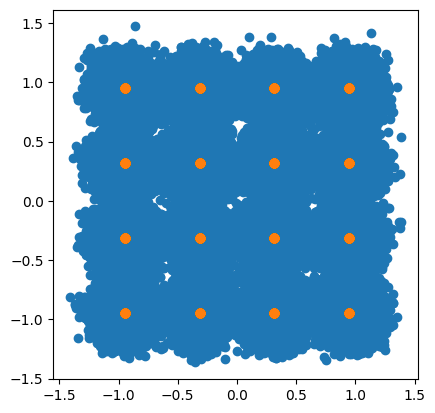

In [65]:
# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

import tensorflow as tf
# For the implementation of the Keras models
from tensorflow import keras
from keras import Model
# for performance measurements
import time

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber

# Binary Source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)

# SymbolDemapper
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)

k = 512 # Block Length
no = 0.2 # Noise variance of the channel
NUM_TX_ANT = 4 # Transmit Antennas
NUM_RX_ANT = 16 # Receive Antennas
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 1024 # Parallel in 32 batches
EBN0_DB_MIN = -30.0 # Minimum Eb/N0 [dB]
EBN0_DB_MAX = 10.0 # Maximum Eb/N0 [dB]
snrs = []
bers = []
sers_zf = []
sers_lmmse = []

b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
print('b shape =',b.shape)

x = mapper(b)
print('x shape =',x.shape)

shape = tf.shape(x)
x_reshape = tf.reshape(x,[-1, NUM_TX_ANT])
print('x reshape =',x_reshape.shape)

y, h = flatfading_channel([x_reshape, no])
print('y shape =',y.shape)
print('h shape =',h.shape)

s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)

x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)
print('x_hat_lmmse.shape =',x_hat_lmmse.shape)
print('no_eff_lmmse shape =',no_eff_lmmse.shape)

noise_var_eff_lmmse = np.var(x_reshape-x_hat_lmmse)
noise_var_est_lmmse = np.mean(no_eff_lmmse)
print('noise_var_eff_lmmse =',noise_var_eff_lmmse)
print('noise_var_est_lmmse =',noise_var_est_lmmse)

plt.axes().set_aspect(1.0)
plt.scatter(np.real(x_hat_lmmse), np.imag(x_hat_lmmse))
plt.scatter(np.real(x), np.imag(x))

# equalization

Number of GPUs available : 0
b shape = (8, 4, 512)
x shape = (8, 4, 128)
x reshape = (1024, 4)
y shape = (1024, 16)
h = tf.Tensor(
[[[ 0.94818705-0.41510788j  0.41324094+0.8743232j
    0.57115954-0.30774373j -0.13890281+0.7499641j ]
  [-0.37446302+0.13489811j -0.0098919 -0.3351228j
   -2.3209057 -0.22558984j  0.38042596+0.256313j  ]
  [-1.5350255 -0.10783753j  0.6520335 -0.7204042j
   -0.5521754 -2.2758398j  -0.1479411 -0.05568101j]
  ...
  [-0.7134954 -0.08686045j  0.7717588 -0.05457621j
   -0.62089276+0.55730164j -0.14817235-0.12870063j]
  [-0.94133043-0.2373915j  -0.55637926+0.51277053j
   -0.57679003+0.4785613j  -1.6551428 +0.543314j  ]
  [-0.81364757+0.01800449j  0.39616624-1.5002128j
    0.75979364+0.78469205j  1.1649046 +0.16965114j]]

 [[-0.77454096+0.93184555j -0.7627009 +1.4571441j
   -0.4214469 -0.5843185j  -0.60840297-0.55268824j]
  [-0.43329746+0.25814205j -1.077129  +0.05205736j
    0.3914225 -0.11556157j -1.1799728 +0.1369083j ]
  [-0.9975381 +0.58130705j  0.40683475-0.0

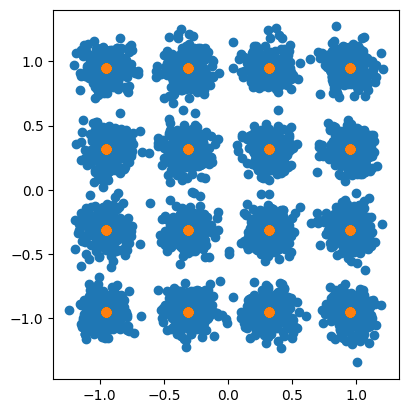

In [71]:
# GPU Configuration and Imports
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 0 # Number of the GPU to be used
    try:
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

import tensorflow as tf
# For the implementation of the Keras models
from tensorflow import keras
from keras import Model
# for performance measurements
import time

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

# Import Sionna
try:
    import sionna as sn
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna as sn
    
from sionna.utils import BinarySource, QAMSource, ebnodb2no, compute_ser, compute_ber, PlotBER
from sionna.channel import FlatFadingChannel, KroneckerModel
from sionna.channel.utils import exp_corr_mat
# from sionna.mimo import lmmse_equalizer, zf_equalizer
from sionna.mapping import SymbolDemapper, Mapper, Demapper
from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.utils.misc import hard_decisions
from sionna.utils.metrics import compute_ber

from sionna.utils import expand_to_rank, matrix_inv, matrix_pinv
from sionna.mimo.utils import whiten_channel

def lmmse_equalizer(y, h, s, whiten_interference=True):
    if not whiten_interference:
        # Compute G
        g = tf.matmul(h, h, adjoint_b=True) + s
        g = tf.matmul(h, matrix_inv(g), adjoint_a=True)

    else:
        # Whiten channel
        y, h  = whiten_channel(y, h, s, return_s=False) # type: ignore

        # Compute G
        i = expand_to_rank(tf.eye(h.shape[-1], dtype=s.dtype), tf.rank(s), 0)
        g = tf.matmul(h, h, adjoint_a=True) + i
        g = tf.matmul(matrix_inv(g), h, adjoint_b=True)

    # Compute Gy
    y = tf.expand_dims(y, -1)
    gy = tf.squeeze(tf.matmul(g, y), axis=-1)

    # Compute GH
    gh = tf.matmul(g, h)

    # Compute diag(GH)
    d = tf.linalg.diag_part(gh)

    # Compute x_hat
    x_hat = gy/d

    # Compute residual error variance
    one = tf.cast(1, dtype=d.dtype)
    no_eff = tf.math.real(one/d - one)

    return x_hat, no_eff

def zf_equalizer(y, h, s):
    # Compute G
    g = matrix_pinv(h)

    # Compute x_hat
    y = tf.expand_dims(y, -1)
    x_hat = tf.squeeze(tf.matmul(g, y), axis=-1)

    # Compute residual error variance
    gsg = tf.matmul(tf.matmul(g, s), g, adjoint_b=True)
    no_eff = tf.math.real(tf.linalg.diag_part(gsg))

    return x_hat, no_eff

def mf_equalizer(y, h, s):
    # Compute G
    hth = tf.matmul(h, h, adjoint_a=True)
    d = tf.linalg.diag(tf.cast(1, h.dtype)/tf.linalg.diag_part(hth))
    g = tf.matmul(d, h, adjoint_b=True)

    # Compute x_hat
    y = tf.expand_dims(y, -1)
    x_hat = tf.squeeze(tf.matmul(g, y), axis=-1)

    # Compute residual error variance
    gsg = tf.matmul(tf.matmul(g, s), g, adjoint_b=True)
    gh = tf.matmul(g, h)
    i = expand_to_rank(tf.eye(gsg.shape[-2], dtype=gsg.dtype), tf.rank(gsg), 0)

    no_eff = tf.abs(tf.linalg.diag_part(tf.matmul(i-gh, i-gh, adjoint_b=True) + gsg))
    return x_hat, no_eff


# Binary Source
binary_source = sn.utils.BinarySource()

# Constellation
constellation = sn.mapping.Constellation("qam", NUM_BITS_PER_SYMBOL)
#constellation.show(figsize=(7,7));

# Mapper and Demapper
mapper = sn.mapping.Mapper(constellation=constellation)
# The demapper uses the same constellation object as the mapper
demapper = sn.mapping.Demapper("app", constellation=constellation)

# AWGN Channel
awgn_channel = sn.channel.AWGN()

# Flat Fading Channel
# To simulate transmissions over an i.i.d. Rayleigh fading channel. The channel will also add AWGN with variance `no`.
flatfading_channel = FlatFadingChannel(NUM_TX_ANT, NUM_RX_ANT, add_awgn=True, return_channel=True)

# SymbolDemapper
symbol_demapper = SymbolDemapper("qam", NUM_BITS_PER_SYMBOL, hard_out=True)

k = 512 # Block Length
no = 0.2 # Noise variance of the channel
NUM_TX_ANT = 4 # Transmit Antennas
NUM_RX_ANT = 16 # Receive Antennas
NUM_BITS_PER_SYMBOL = 4 # 16 QAM
BATCH_SIZE = 8 # Parallelly Processed Batches
EBN0_DB_MIN = -30.0 # Minimum Eb/N0 [dB]
EBN0_DB_MAX = 10.0 # Maximum Eb/N0 [dB]
snrs = []
bers = []
sers_zf = []
sers_lmmse = []

b = binary_source([BATCH_SIZE,NUM_TX_ANT,k])
print('b shape =',b.shape)

x = mapper(b)
print('x shape =',x.shape)

shape = tf.shape(x)
x_reshape = tf.reshape(x,[-1, NUM_TX_ANT])
print('x reshape =',x_reshape.shape)

y, h = flatfading_channel([x_reshape, no])
print('y shape =',y.shape)
# print('h =',h)
print('h shape =',h.shape)

s = tf.cast(no*tf.eye(NUM_RX_ANT, NUM_RX_ANT), y.dtype)
print('s =',s)

x_hat_lmmse, no_eff_lmmse = lmmse_equalizer(y, h, s)
print('x_hat_lmmse.shape =',x_hat_lmmse.shape)
print('no_eff_lmmse shape =',no_eff_lmmse.shape)

noise_var_eff_lmmse = np.var(x_reshape-x_hat_lmmse)
noise_var_est_lmmse = np.mean(no_eff_lmmse)
print('noise_var_eff_lmmse =',noise_var_eff_lmmse)
print('noise_var_est_lmmse =',noise_var_est_lmmse)

plt.axes().set_aspect(1.0)
plt.scatter(np.real(x_hat_lmmse), np.imag(x_hat_lmmse))
plt.scatter(np.real(x), np.imag(x))

# complex_normal

In [79]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Layer
def complex_normal(shape, var=1.0, dtype=tf.complex64):
    # Half the variance for each dimension
    var_dim = tf.cast(var, dtype.real_dtype)/tf.cast(2, dtype.real_dtype) # var_dim = 1/2
    print('var_dim =',var_dim)
    stddev = tf.sqrt(var_dim) # standard deviation = sqrt(variance) = sqrt(1/2) = 0.7071
    print('stddev =',stddev)
 
    # Generate complex Gaussian noise with the right variance
    xr = tf.random.normal(shape, stddev=stddev, dtype=dtype.real_dtype)
    xi = tf.random.normal(shape, stddev=stddev, dtype=dtype.real_dtype)
    x = tf.complex(xr, xi)
    print('x =',x)
 
    return x

shape = [4,3,2];
complex_normal(shape);

var_dim = tf.Tensor(0.5, shape=(), dtype=float32)
stddev = tf.Tensor(0.70710677, shape=(), dtype=float32)
x = tf.Tensor(
[[[-1.2177651 +0.09163907j -0.0687925 +0.63868874j]
  [ 0.12732428-0.741966j    0.70574963+0.3686277j ]
  [ 0.8471744 +0.89642155j -0.61999476+0.5020816j ]]

 [[ 0.3094684 +0.8396757j  -0.17501539-0.47946107j]
  [ 0.73089117-0.8029014j   0.10686365-0.96113425j]
  [ 1.6795001 +0.4054319j  -0.9734228 -0.9575875j ]]

 [[-1.085868  +0.27700955j  1.0796782 -0.18337949j]
  [-0.9778669 +0.21080385j  0.24215956+2.03898j   ]
  [ 0.23300657+0.16278j     1.1952568 +0.32316047j]]

 [[-0.6072106 +0.32206395j -0.7255045 +0.20543936j]
  [ 0.76360106-0.10037783j  0.32929915-1.532512j  ]
  [ 0.10845231+0.46006835j  1.1205252 -0.05848385j]]], shape=(4, 3, 2), dtype=complex64)
